In [60]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import ahkab
import numpy as np
import matplotlib.pyplot as plt
import sympy
from sympy.abc import w
from sympy import I
import scipy, scipy.interpolate
print("We're using ahkab %s" % ahkab.__version__)

We're using ahkab 0.18


In [86]:
lpf = ahkab.Circuit('2nd Order Sallen-Key LPF')
# https://en.wikipedia.org/wiki/Sallen–Key_topology
R1 = 10e3
R2 = 10e3
C1 = 1e-9
C2 = 1e-9
Av = 100

bw = 1/np.sqrt(R1*R2*C1*C2)/2/np.pi
print("3db frequency should be: %g Hz" % (bw))

lpf.add_resistor('R1', 'in', 'n1', R1)
lpf.add_resistor('R2', 'n1', 'n2', R2)
lpf.add_capacitor('C1', 'n1', 'out', C1)
lpf.add_capacitor('C2', 'n2', lpf.gnd, C2)
lpf.add_vcvs('E1', 'out', lpf.gnd, 'n2', 'out', Av)

# we also give V1 an AC value since we wish to run an AC simulation
lpf.add_vsource('V1', 'in', lpf.gnd, dc_value=0, ac_value=1)
print(lpf)

3db frequency should be: 15915.5 Hz
* 2nd Order Sallen-Key LPF
R1 in n1 10000
R2 n1 n2 10000
C1 n1 out 1e-09
C2 n2 0 1e-09
E1 out 0 n2 out 100
V1 in 0 type=vdc value=0 vac=1 


In [91]:
opa = ahkab.new_op()
aca = ahkab.new_ac(start=1e2, stop=1e5, points=100)
pza = ahkab.new_pz('V1', ('out', lpf.gnd), x0=None, shift=1e3)
syma = ahkab.new_symbolic(source='V1')
r = ahkab.run(lpf, [opa, aca, pza])
rs, tfs = ahkab.run(lpf, syma)['symbolic']
r['op'].keys()
r['ac'].keys()
#r['pz'].keys() #pz analysis didn't work

# Print symbolic solution
print(rs)
Hs = tfs['VOUT/V1']['gain']
print("Transfer function: %s" % Hs)
print("Poles: %s" % tfs['VOUT/V1']['poles'])
p0 = tfs['VOUT/V1']['poles'][0]
p1 = tfs['VOUT/V1']['poles'][1]

['VIN', 'VN1', 'VN2', 'VOUT', 'I(E1)', 'I(V1)']

['f', 'Vin', 'Vn1', 'Vn2', 'Vout', 'I(E1)', 'I(V1)']

Symbolic simulation results for '2nd Order Sallen-Key LPF' (netlist None).
Run on 2019-03-14 00:29:38.
I[E1]	 = C1*C2*R2*V1*s**2/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
I[V1]	 = -C2*V1*s*(C1*R2*s + 1.0)/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
VIN	 = V1
VN1	 = V1*(C2*R2*s + 1.0)/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
VN2	 = V1/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
VOUT	 = V1/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)

Transfer function: 1/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
Poles: [0.5*(-sqrt(C2)*(R1 + R2) + sqrt(-4.0*C1*R1*R2 + C2*R1**2 + 2.0*C2*R1*R2 + C2*R2**2))/(C1*sqrt(C2)*R1*R2), -0.5*(sqrt(C2)*(R1 + R2) + sqrt(-4.0*C1*R1*R2 + C2*R1**2 + 2.0*C2*R1*R2 + C2*R2**2))/(C1*sqrt(C2)*R1*R2)]


In [95]:
s, R1, R2, C1, C2 = rs.as_symbols('s R1 R2 C1 C2')
HS = sympy.lambdify(w, Hs.subs({s:I*w*2*np.pi, R1:10e3, R2:10e3, C1:1e-9, C2:1e-9}))
p0s = np.abs(p0.subs({R1:10e3, R2:10e3, C1:1e-9, C2:1e-9}))/2/np.pi
p1s = np.abs(p1.subs({R1:10e3, R2:10e3, C1:1e-9, C2:1e-9}))/2/np.pi
print("First pole: %g Hz" % p0s)
print("Second pole: %g Hz" % p1s)

First pole: 15915.5 Hz
Second pole: 15915.5 Hz


Text(0, 0.5, '|H(s)| [dB]')

Text(0.5, 1.0, '2nd Order Sallen-Key LPF - AC Simulation')

Text(0.5, 0, 'Frequency [Hz]')

Text(0, 0.5, 'Phase [deg]')

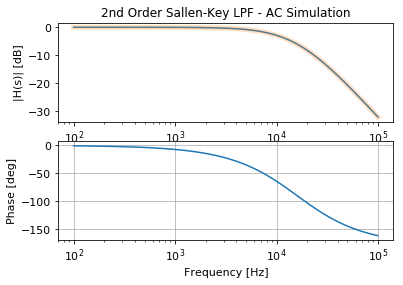

In [88]:
fig = plt.figure()
plt.subplot(211)
plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(r['ac']['Vout'])), '-', label='H(s) from AC analysis')
plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(HS(r['ac'].get_x()))), '-', lw=5, alpha=.25, label='H(s) from symbolic')
plt.ylabel('|H(s)| [dB]')
plt.title(lpf.title + " - AC Simulation")
plt.subplot(212)
plt.grid(True)
plt.semilogx(r['ac']['f'], 180/np.pi*np.angle(r['ac']['Vout']), '-')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
#fig.savefig('ac_plot.png')
plt.show()

In [87]:
# DC gain
dc_gain = 20*np.log10(np.abs(r['ac']['Vout'][0]))
print("DC gain: %g dB" % (dc_gain))

# Normalize the output to the low frequency value and convert to array
norm_out = np.abs(r['ac']['Vout'])/np.abs(r['ac']['Vout']).max()
# Convert to dB
norm_out_db = 20*np.log10(norm_out)
# Get frequencies
frequencies = r['ac']['f']
# call scipy to interpolate
norm_out_db_interpolated = scipy.interpolate.interp1d(frequencies, norm_out_db)

print("Maximum attenuation in the pass band (0-%g Hz) is %g dB" % (bw, -1.0*norm_out_db_interpolated(bw)))
print("Minimum attenuation in the stop band (%g Hz - Inf) is %g dB" % (20e3, -1.0*norm_out_db_interpolated(20e3)))

DC gain: -0.000343159 dB
Maximum attenuation in the pass band (0-15915.5 Hz) is 6.02029 dB
Minimum attenuation in the stop band (20000 Hz - Inf) is 8.22882 dB
